# Upwind Methods

## Shocktube Test Cases

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
import pyflow
from pyflow.euler.fvm import *
from pyflow.euler.model import PrimitiveState, Euler, CaloricallyPerfectGas
from pyflow.euler.problems import ShocktubeProblem

## Euler Equations 

The Euler equations in one-dimension are given as

$$
\begin{align}
& \frac{\partial \rho}{\partial t} + \frac{\partial \rho u}{\partial x} = 0 \\
& \frac{\partial \rho u}{\partial t} + \frac{\partial (\rho u^2 + p)}{\partial x} = 0 \\
& \frac{\partial \rho e}{\partial t} + \frac{\partial}{\partial x}\Big[ \left(e + p\right)u \Big] = 0
\end{align}
$$

which can be written in conservation law form

$$
\frac{\partial \mathbf{U} }{\partial t} + \frac{\partial \mathbf{F}}{\partial x} = 0
$$

where $\mathbf{U}$ is the vector of conserved variables and $\mathbf{F}(\mathbf{U})$ is the vector of fluxes. In general, these definition can be extended to any $m$-number of conservation laws and dimensions; however, for the one-dimensional Euler equations specifically we have

$$
\mathbf{U} = \begin{bmatrix}
\rho \\
\rho u \\
e 
\end{bmatrix}
$$

and

$$
\mathbf{F} = \begin{bmatrix}
\rho u\\
\rho u^2 + p \\
 u (e + p)
\end{bmatrix}
$$

with 

$$
p = (\gamma - 1)\left(e - \rho \frac{u^2}{2}\right)
$$

## Shocktube Test Cases

Shocktube test cases are a standard way of testing the performance of compressible CFD solvers. For an extensive review of test problems for the Euler equations see the accompanying paper by Liska and Wendroff, 2003. 

## Sod Test Case


For use with `pyflow` a shocktube problem is defined by specifying the primitive state vector at the left and right of the diaphragm. To do this, use the `PrimitiveState` object. For example, the following code defines the left and right state vectors.

    left = PrimitiveState(density=1.0, speed=0.0, pressure=1.0)
    right = PrimitiveState(density=0.125, speed=0.0, pressure=0.1)

These can then be used to define a shocktube problem:

    Sod = ShocktubeProblem(left, right, x0=0.3, Nx=50)

where `x0` is the location of the diaphragm and `Nx` is the number of cells used to discretize the domain. Additionally, the specific heat ratio $\gamma$ can also be specified. For example, to change the value of the specific heat ratio from the default of 1.4 to $\gamma = 5/3$, 


    Sod = ShocktubeProblem(left, right, x0=0.3, Nx=50, gamma=5/3)

In [3]:
left = PrimitiveState(density=1.0, speed=0.0, pressure=1.0)
right = PrimitiveState(density=0.125, speed=0.0, pressure=0.1)

Sod = ShocktubeProblem(left, right, x0=0.5, Nx=50)

# Define the CFL number to use for the numerical methods
CFL = 0.8

# Final simulation time
time = 0.25

print(Sod)

  Shocktube problem:

    Length              : 1.0

    Diaphragm           : 0.5

    Cells               : 50

    Specific Heat Ratio : 1.4

    Left State          : PrimitiveState(density=1.0, speed=0.0, pressure=1.0)

    Right State         : PrimitiveState(density=0.125, speed=0.0, pressure=0.1)



In [4]:
# Find the exact solution
exact = Sod.exact_solution(time)

In [5]:
# Compute the solution using MacCormack's predictor-corrector method

MCMethod = MacCormackMethod(Sod, CFL=CFL)
MCMethod.solve(time, dissipation=0.0)
MC = MCMethod.get_primitives()

MCMethod.solve(time, dissipation=0.1)
MC_dissipation = MCMethod.get_primitives()



Simulation Complete
Final time = 0.25
Total number of iterations = 37


Simulation Complete
Final time = 0.25
Total number of iterations = 33


<IPython.core.display.Javascript object>


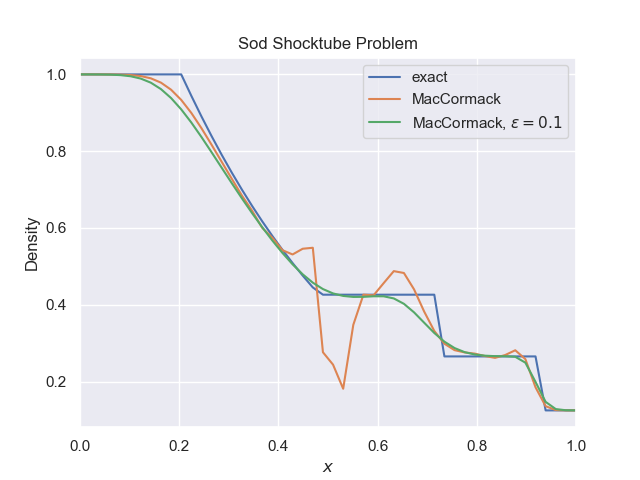

Text(0.5, 1.0, 'Sod Shocktube Problem')

In [6]:
fig, ax = plt.subplots()
ax.plot(exact.x, exact.density, label="exact")
ax.plot(MC.x, MC.density, label="MacCormack")
ax.plot(MC_dissipation.x, MC_dissipation.density, label=r'MacCormack, $\epsilon = 0.1$')

ax.set_xlabel(r'$x$')
ax.set_ylabel('Density')
ax.set_xlim((0,1))
ax.legend()
plt.title('Sod Shocktube Problem')

In [7]:
# Compute the solution using the flux-vector splitting method of Steger and Warming.

SWMethod = StegerWarmingMethod(Sod, CFL=CFL)
SWMethod.solve(time)

SW = SWMethod.get_primitives()



Simulation Complete
Final time = 0.25
Total number of iterations = 33


In [8]:
# Compute the solution using varius Riemann solvers.

# Godunov's first order method -- uses an exact Riemann solver for the Euler equations
Upwind = GodunovMethod(Sod, CFL=CFL)
Upwind.solve(time)
G = Upwind.get_primitives()

# Use the HLL approximate Riemann solver
ApproxRiemannHLL = HLLMethod(Sod, CFL=CFL)
ApproxRiemannHLL.solve(time)

HLL = ApproxRiemannHLL.get_primitives()

# Use the HLLC approximate Riemann solver
ApproxRiemannHLLC = HLLCMethod(Sod, CFL=CFL)
ApproxRiemannHLLC.solve(time)

HLLC = ApproxRiemannHLLC.get_primitives()




Simulation Complete
Final time = 0.25
Total number of iterations = 33


Simulation Complete
Final time = 0.25
Total number of iterations = 32


Simulation Complete
Final time = 0.25
Total number of iterations = 32


<IPython.core.display.Javascript object>


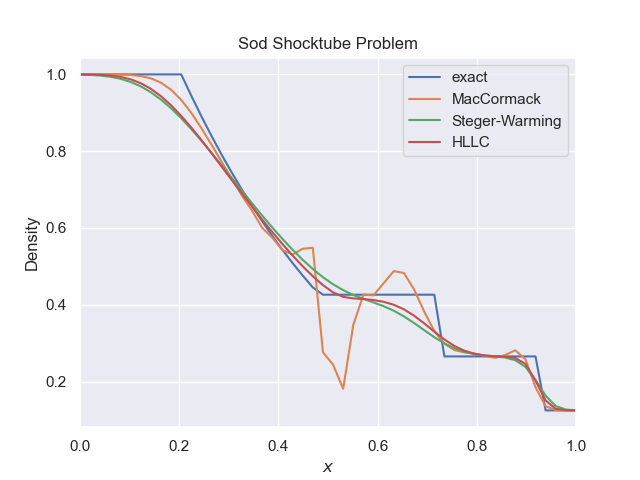

Text(0.5, 1.0, 'Sod Shocktube Problem')

In [9]:
fig, ax = plt.subplots()
ax.plot(exact.x, exact.density, label="exact")
ax.plot(MC.x, MC.density, label="MacCormack")
ax.plot(SW.x, SW.density, marker='s', ms=0, label="Steger-Warming")
ax.plot(HLLC.x, HLLC.density, marker='s', ms=0, label="HLLC")

ax.set_xlabel(r'$x$')
ax.set_ylabel('Density')
ax.set_xlim((0,1))
# ax.set_ylim((0,1))
ax.legend()
plt.title('Sod Shocktube Problem')

<IPython.core.display.Javascript object>


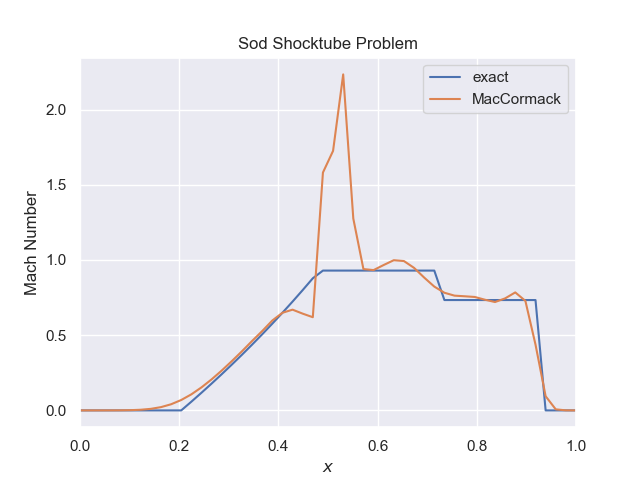

Text(0.5, 1.0, 'Sod Shocktube Problem')

In [10]:
def mach_number(solution):
    CPG = Euler(CaloricallyPerfectGas(gamma=1.4))
    return solution.speed / CPG.Thermodynamics.speed_of_sound(solution.density, solution.pressure)

fig, ax = plt.subplots()
ax.plot(exact.x, mach_number(exact), label="exact")
ax.plot(MC.x, mach_number(MC), label="MacCormack")

ax.set_xlabel(r'$x$')
ax.set_ylabel('Mach Number')
ax.set_xlim((0,1))
# ax.set_ylim((0,1))
ax.legend()
plt.title('Sod Shocktube Problem')

### Timing of the methods

We need to increase number of cells used to discretize the domain so that we get a better indicator of the computational time it takes for each method.

In [ ]:
# # Compute the solution using varius Riemann solvers.

# Sod = ShocktubeProblem(left, right, x0=0.5, Nx=200)

# # Compute the solution using MacCormack's predictor-corrector method
# print('MacCormack method:')
# %timeit MC = MacCormackMethod(Sod, CFL=CFL, dissipation=0.1).solve(time)
# print('')

# # Compute the solution using the flux-vector splitting method of Steger and Warming.
# print('Steger-Warming method:')
# %timeit SW = StegerWarmingMethod(Sod, CFL=CFL).solve(time)
# print('')

# # Godunov's first order method -- uses an exact Riemann solver for the Euler equations
# print('First order upwind with Exact Riemann solver:')
# %timeit G = GodunovMethod(Sod, CFL=CFL).solve(time)
# print('')

# # Use the HLL approximate Riemann solver
# print('First order upwind with HLL approximate Riemann solver:')
# %timeit HLL = HLLMethod(Sod, CFL=CFL).solve(time)
# print('')

# # Use the HLLC approximate Riemann solver
# print('First order upwind with HLLC approximate Riemann solver:')
# %timeit HLLC = HLLCMethod(Sod, CFL=CFL).solve(time)
# print('')

## Toro's modified Sod test case

This is Toro’s variant of Sod’s Riemann problem, which was defined above. It differs from Sod’s shocktube test in that there is a sonic point in the rarefaction. 

The left and right states are defined as:
- Left State
   * Density: $\rho = 1.0$ 
   * Speed: $u = 0.75$
   * Pressure: $p = 1.0$
   
- Right State
   * Density: $\rho = 0.125$ 
   * Speed: $u = 0.0$
   * Pressure: $p = 0.1$
   
The diaphragm is located at $x_0 = 0.3$, and the solution is computed at 0.2 time units.

In [ ]:
left = PrimitiveState(density=1.0, speed=0.75, pressure=1.0)
right = PrimitiveState(density=0.125, speed=0.0, pressure=0.1)

ToroSod = ShocktubeProblem(left, right, x0=0.3, Nx=50)

# Define the CFL number to use for the numerical methods
CFL = 0.8

# Final simulation time
time = 0.2

print(ToroSod)

### Riemann problem where the central state is near vacuum

In this Riemann problem, the central state approaches a vacuum, where $\rho$ and $p$ are near zero. Numerical schemes are often not able to predict the internal energy very well.

In [ ]:
left = PrimitiveState(density=1.0, speed=-2.0, pressure=0.4)
right = PrimitiveState(density=1.0, speed=2.0, pressure=0.4)

RP2 = ShocktubeProblem(left, right, x0=0.5, Nx=50)

CFL = 0.8

time = 0.15

### Noh's Shocktube Test

This test case consists of the infinite strength shocks moving out from the center, leaving a constant density and pressure state behind.

In [ ]:
left = PrimitiveState(density=1.0, speed=1.0, pressure=1.0e-6)
right = PrimitiveState(density=1.0, speed=-1.0, pressure=1.0e-6)

Noh = ShocktubeProblem(left, right, x0=0.5, Nx=100)

CFL = 0.8

time = 1

# References

1. Liska, R. and B. Wendroff (2003), *Comparison of several difference schemes on 1D and 2D test problems for the Euler equations*, SIAM J. Sci. Comput., **25** (3), 995-1017